In [1]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, random_split
from torchvision import transforms
import torch.optim as optim
import time
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import copy
from tqdm import tqdm


class RoadDataset(Dataset):
    def __init__(self, path, img_size=(256, 512)):
        self.path = path
        self.segmentation_name_list = os.listdir(os.path.join(path, "gt_image_2"))
        self.image_name_list = os.listdir(os.path.join(path, "image_2"))
        self.img_size = img_size

    def __len__(self):
        return len(self.segmentation_name_list)

    def __getitem__(self, idx):
        segmentation_name = self.segmentation_name_list[idx]
        segmentation_path = os.path.join(self.path, "gt_image_2", segmentation_name)
        image_name = self.image_name_list[idx]
        image_path = os.path.join(self.path, "image_2", image_name)

        segmentation_img = Image.open(segmentation_path).convert("RGB")
        image_img = Image.open(image_path).convert("RGB")

        resize = transforms.Resize(self.img_size)
        segmentation_img = resize(segmentation_img)
        image_img = resize(image_img)

        image_tensor = transforms.ToTensor()(image_img)
        
        segmentation_array = np.array(segmentation_img)
        road_mask = np.zeros(segmentation_array.shape[:2], dtype=np.float32)
        road_mask[(segmentation_array[:, :, 0] == 255) & 
                  (segmentation_array[:, :, 1] == 0) & 
                  (segmentation_array[:, :, 2] == 255)] = 1.0

        segmentation_tensor = torch.tensor(road_mask, dtype=torch.float32).unsqueeze(0)
        return image_tensor, segmentation_tensor


In [2]:
import torch.nn.functional as F


class AdaptivePadding:
    def pad(self, x):
        self.original_size = (x.size(2), x.size(3))
        pad_h = (16 - self.original_size[0] % 16) % 16
        pad_w = (16 - self.original_size[1] % 16) % 16
        return F.pad(x, (0, pad_w, 0, pad_h))
    
    def crop(self, x, target_size=None):
        if target_size is None:
            target_size = self.original_size

        return x[:, :, :target_size[0], :target_size[1]]


class Conv_Block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Conv_Block, self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.Dropout2d(),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.Dropout2d(),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.layer(x)
    

class UNet(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]
            ):
        super(UNet, self).__init__()
        self.upsample = nn.ModuleList()
        self.downsample = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Downsampling path
        for feature in features:
            self.downsample.append(Conv_Block(in_channels, feature))
            in_channels = feature

        # Bottleneck
        self.bottleneck = Conv_Block(features[-1], features[-1] * 2)

        # Upsampling path
        for feature in reversed(features):
            self.upsample.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.upsample.append(Conv_Block(feature * 2, feature))

        # Final output layer
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

        self.padding = AdaptivePadding()

    def forward(self, x):
        original_size = x.shape[2:]
        x = self.padding.pad(x)

        skip_connections = []

        for down in self.downsample:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)

        skip_connections = skip_connections[::-1]

        
        for i in range(0, len(self.upsample), 2):
            x = self.upsample[i](x)
            skip_connection = skip_connections[i // 2]
            
            """
            if x.shape[2:] != skip_connection.shape[2:]:
                diffy = skip_connection.size()[2] - x.size()[2]
                diffx = skip_connection.size()[3] - x.size()[3]
                x = F.pad(x, [diffx // 2, diffx - diffx // 2,
                              diffy // 2, diffy - diffy // 2])
            """
            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.upsample[i + 1](concat_skip)

        x = self.final_conv(x)
        return self.padding.crop(x, original_size)


Dataset length: 289
Image shape: torch.Size([3, 256, 512])
Segmentation shape: torch.Size([1, 256, 512])
231 58
29
8


Epoch 1/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.67it/s, acc=tensor(0.1443, device='cuda:0'), iou=0.144, loss=0.778]


Epoch 1/10 | Time: 14.2s
Train Loss: 0.7942 | Train IoU: 0.2010 | Train Acc: 0.4326
Val Loss: 0.7630 | Val IoU: 0.1772 | Val Acc: 0.1772


Epoch 2/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.84it/s, acc=tensor(0.1836, device='cuda:0'), iou=0.151, loss=0.839]


Epoch 2/10 | Time: 13.5s
Train Loss: 0.7140 | Train IoU: 0.2652 | Train Acc: 0.5243
Val Loss: 0.8016 | Val IoU: 0.1900 | Val Acc: 0.2426


Epoch 3/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.80it/s, acc=tensor(0.4365, device='cuda:0'), iou=0.221, loss=0.808]


Epoch 3/10 | Time: 13.6s
Train Loss: 0.6562 | Train IoU: 0.3211 | Train Acc: 0.6106
Val Loss: 0.7729 | Val IoU: 0.2658 | Val Acc: 0.4962


Epoch 4/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.81it/s, acc=tensor(0.4656, device='cuda:0'), iou=0.241, loss=0.809]


Epoch 4/10 | Time: 13.6s
Train Loss: 0.6208 | Train IoU: 0.3658 | Train Acc: 0.6741
Val Loss: 0.7792 | Val IoU: 0.2834 | Val Acc: 0.5250


Epoch 5/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.84it/s, acc=tensor(0.4839, device='cuda:0'), iou=0.253, loss=0.867]


Epoch 5/10 | Time: 13.5s
Train Loss: 0.5696 | Train IoU: 0.4053 | Train Acc: 0.7471
Val Loss: 0.8378 | Val IoU: 0.2897 | Val Acc: 0.5357


Epoch 6/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s, acc=tensor(0.3510, device='cuda:0'), iou=0.192, loss=1]    


Epoch 6/10 | Time: 13.4s
Train Loss: 0.5413 | Train IoU: 0.4461 | Train Acc: 0.7822
Val Loss: 0.9666 | Val IoU: 0.2236 | Val Acc: 0.3712


Epoch 7/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.83it/s, acc=tensor(0.2309, device='cuda:0'), iou=0.159, loss=1.26]


Epoch 7/10 | Time: 13.4s
Train Loss: 0.5379 | Train IoU: 0.4520 | Train Acc: 0.7871
Val Loss: 1.2211 | Val IoU: 0.1919 | Val Acc: 0.2527


Epoch 8/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s, acc=tensor(0.4642, device='cuda:0'), iou=0.243, loss=0.928]


Epoch 8/10 | Time: 13.4s
Train Loss: 0.5407 | Train IoU: 0.4627 | Train Acc: 0.7955
Val Loss: 0.9016 | Val IoU: 0.2694 | Val Acc: 0.4902


Epoch 9/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.73it/s, acc=tensor(0.3539, device='cuda:0'), iou=0.194, loss=1.07]


Epoch 9/10 | Time: 13.7s
Train Loss: 0.5427 | Train IoU: 0.4537 | Train Acc: 0.7833
Val Loss: 1.0250 | Val IoU: 0.2262 | Val Acc: 0.3795


Epoch 10/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.75it/s, acc=tensor(0.4586, device='cuda:0'), iou=0.239, loss=0.933]


Epoch 10/10 | Time: 13.5s
Train Loss: 0.5239 | Train IoU: 0.4632 | Train Acc: 0.7893
Val Loss: 0.8965 | Val IoU: 0.2777 | Val Acc: 0.5131


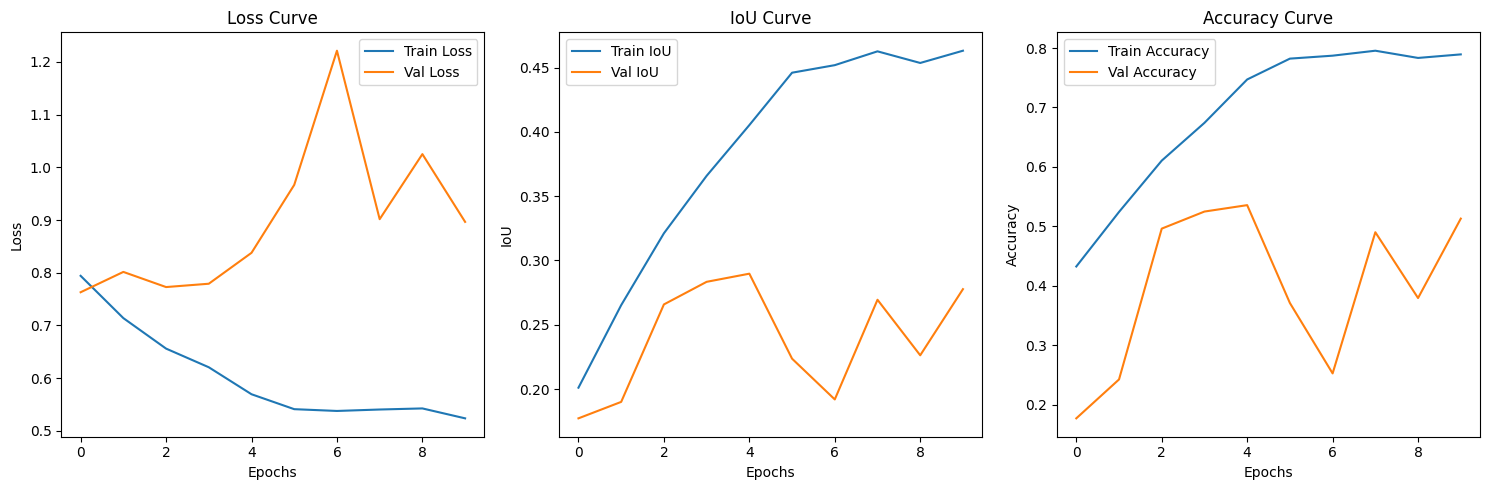

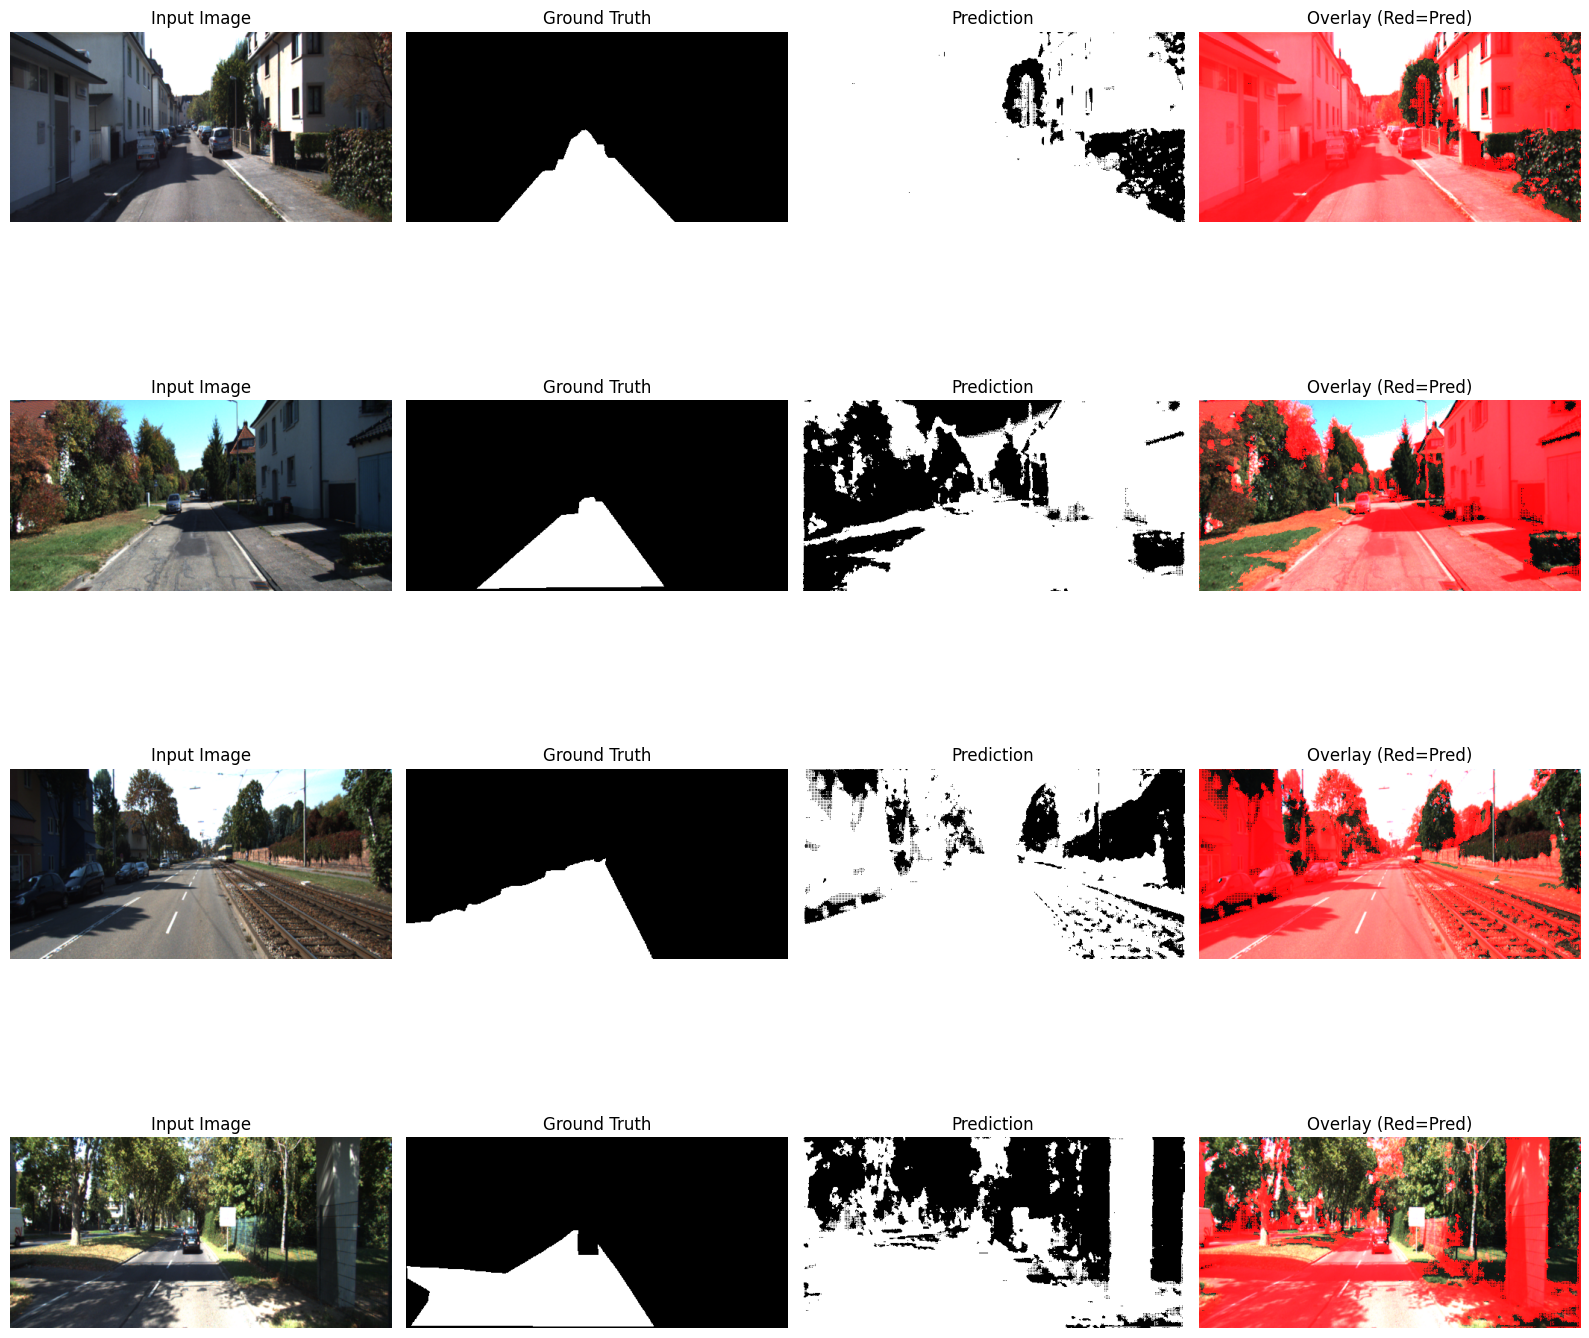

Training completed and model saved!


In [ ]:
def train_model(model, train_loader, val_loader, device, epochs=10, lr=0.001):
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    criterion = nn.BCEWithLogitsLoss()
    
    best_iou = 0.0
    best_model = None
    
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_iou': [],
        'val_iou': [],
        'train_acc': [],
        'val_acc': []
    }
    
    for epoch in range(epochs):
        start_time = time.time()
        
        model.train()
        train_loss = 0.0
        train_iou = 0.0
        train_correct = 0
        train_total = 0

        train_iter = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]", leave=False)
        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, masks)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * images.size(0)
            
            with torch.no_grad():
                preds = torch.sigmoid(outputs) > 0.5
                iou = calculate_iou(preds, masks)
                acc = calculate_accuracy(preds, masks)
                
                train_iou += iou.item() * images.size(0)
                train_correct += (preds == masks).sum().item()
                train_total += masks.numel()
            
            train_iter.set_postfix(loss=loss.item(), iou=iou.item(), acc=acc)
        
        model.eval()
        val_loss = 0.0
        val_iou = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            val_iter = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]", leave=True)
            for images, masks in val_iter:
                images, masks = images.to(device), masks.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, masks)
                
                val_loss += loss.item() * images.size(0)
                
                preds = torch.sigmoid(outputs) > 0.5
                iou = calculate_iou(preds, masks)
                acc = calculate_accuracy(preds, masks)
                
                val_iou += iou.item() * images.size(0)
                val_correct += (preds == masks).sum().item()
                val_total += masks.numel()
                
                val_iter.set_postfix(loss=loss.item(), iou=iou.item(), acc=acc)
        
        train_loss = train_loss / len(train_loader.dataset)
        val_loss = val_loss / len(val_loader.dataset)
        train_iou = train_iou / len(train_loader.dataset)
        val_iou = val_iou / len(val_loader.dataset)
        train_acc = train_correct / train_total
        val_acc = val_correct / val_total
        
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_iou'].append(train_iou)
        history['val_iou'].append(val_iou)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        
        if val_iou > best_iou:
            best_iou = val_iou
            best_model = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), 'best_model.pth')
        
        epoch_time = time.time() - start_time
        print(f"Epoch {epoch+1}/{epochs} | Time: {epoch_time:.1f}s")
        print(f"Train Loss: {train_loss:.4f} | Train IoU: {train_iou:.4f} | Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f} | Val IoU: {val_iou:.4f} | Val Acc: {val_acc:.4f}")
        
        if best_model:
            model.load_state_dict(best_model)
    
    return model, history


def calculate_iou(preds, targets):
    preds = preds.float()
    targets = targets.float()
    intersection = (preds * targets).sum((1, 2, 3))
    union = (preds + targets).sum((1, 2, 3)) - intersection
    return ((intersection + 1e-6) / (union + 1e-6)).mean()


def calculate_accuracy(preds, targets):
    return (preds == targets).float().mean()


def plot_results(history):
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 3, 2)
    plt.plot(history['train_iou'], label='Train IoU')
    plt.plot(history['val_iou'], label='Val IoU')
    plt.title('IoU Curve')
    plt.xlabel('Epochs')
    plt.ylabel('IoU')
    plt.legend()
    
    plt.subplot(1, 3, 3)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Val Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('training_metrics.png')
    plt.show()

def visualize_predictions(model, loader, device, num_samples=4):
    model.eval()
    fig, axes = plt.subplots(num_samples, 4, figsize=(16, 4*num_samples))
    
    with torch.no_grad():
        for i, (images, masks) in enumerate(loader):
            if i >= num_samples:
                break
                
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            preds = torch.sigmoid(outputs) > 0.5
            
            img = images[0].cpu().permute(1, 2, 0).numpy()
            mask = masks[0, 0].cpu().numpy()
            pred = preds[0, 0].cpu().numpy()
            
            overlay = img.copy()
            overlay[pred == 1, 0] = 1.0
            
            axes[i, 0].imshow(img)
            axes[i, 0].set_title('Input Image')
            axes[i, 0].axis('off')
            
            axes[i, 1].imshow(mask, cmap='gray')
            axes[i, 1].set_title('Ground Truth')
            axes[i, 1].axis('off')
            
            axes[i, 2].imshow(pred, cmap='gray')
            axes[i, 2].set_title('Prediction')
            axes[i, 2].axis('off')
            
            axes[i, 3].imshow(overlay)
            axes[i, 3].set_title('Overlay (Red=Pred)')
            axes[i, 3].axis('off')
    
    plt.tight_layout()
    plt.savefig('predictions.png')
    plt.show()


def main():
    # Constants
    DATA_PATH = r'C:\Users\Louis\Documents\Mark\Road-Detection-using-CNN\data_road\training'
    BATCH_SIZE = 8
    LEARNING_RATE = 1e-4
    EPOCHS = 50
    IMG_SIZE = (375, 1242)
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    dataset = RoadDataset(DATA_PATH)
    print(f"Dataset length: {len(dataset)}")
    image, segmentation = dataset[0]  # Get the first item
    print(f"Image shape: {image.shape}")
    print(f"Segmentation shape: {segmentation.shape}")

    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset,
                                                            [train_size, val_size],
                                                            generator=torch.Generator().manual_seed(42))

    train_loader = torch.utils.data.DataLoader(train_dataset,
                                            batch_size=BATCH_SIZE,
                                            shuffle=True, num_workers=0)
    val_loader = torch.utils.data.DataLoader(val_dataset,
                                            batch_size=BATCH_SIZE,
                                            shuffle=False, num_workers=0)

    print(train_size, val_size)
    print(len(train_loader))
    print(len(val_loader))

    model = UNet(in_channels=3, out_channels=1).to(DEVICE)
    # print(f"Model created with {sum(p.numel() for p in model.parameters()):,} parameters")
    
    trained_model, history = train_model(
        model, train_loader, val_loader, DEVICE, epochs=EPOCHS, lr=LEARNING_RATE
    )
    
    plot_results(history)
    visualize_predictions(trained_model, val_loader, DEVICE)
    
    torch.save(trained_model.state_dict(), 'final_model.pth')
    print("Training completed and model saved!")

if __name__ == "__main__":
    main()
    